In [29]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import pandas as pd
import numpy as np
from chromadb.li_index.search.li.clustering import ClusteringAlgorithm, algorithms
from typing import Any, Dict, List, Optional, Tuple
import numpy.typing as npt
import time

## Create Synthetic Clusters

In [30]:
# Number of clusters and their colors
n_clusters = 4
colors = ['red', 'green', 'blue', 'purple']

# Cluster centers
centers = [[0, 70], [20, 50], [50, 20], [70, 0]]

# Generate a synthetic dataset with minimal overlap between clusters
X, y = make_blobs(n_samples=100, centers=centers, n_features=2, cluster_std=2, random_state=2023)

# Create a DataFrame to hold the dataset
df = pd.DataFrame(X, columns=['x', 'y'])

# Mapping from cluster label to color and replacing cluster labels with colors in the DataFrame
cluster_color_map = {i: colors[i] for i in range(n_clusters)}
df['cluster'] = [cluster_color_map[label] for label in y]

df['id'] = [f"id{i+1}" for i in range(df.shape[0])]

## Visualize Created Clusters

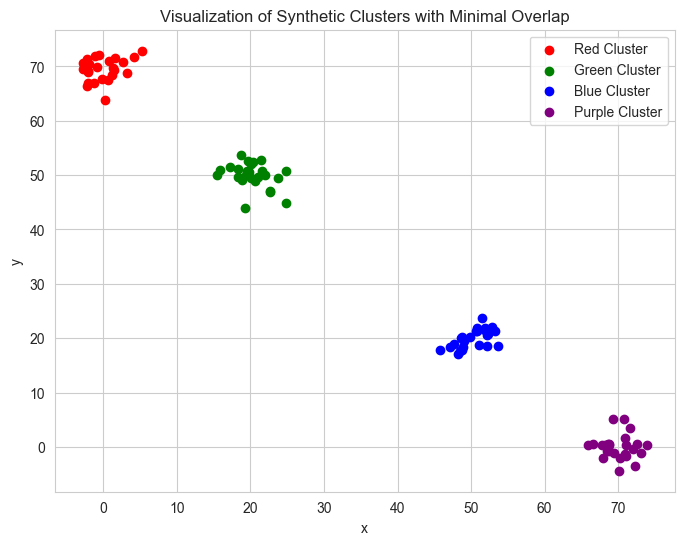

In [31]:
# Visualization of the clusters with distinct colors
plt.figure(figsize=(8, 6))
for color in colors:
    # Select data points belonging to each cluster/color
    cluster_data = df[df['cluster'] == color]
    plt.scatter(cluster_data['x'], cluster_data['y'], color=color, label=f'{color.capitalize()} Cluster')

plt.title('Visualization of Synthetic Clusters with Minimal Overlap')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

### Save the DataFrame for LMI test

In [32]:
# Save the DataFrame to CSV
csv_file_path = './data/synthetic_clusters_colored.csv'
df.to_csv(csv_file_path, index=False)

## Use Faiss Kmeans to cluster the data
We do this to visualize the ground truth that is used for training MLP in LMI

In [33]:
# Method from LearnedIndexBuilder used to cluster the data
def cluster(
    data: pd.DataFrame,
    clustering_algorithm: ClusteringAlgorithm,
    n_clusters: int,
) -> Tuple[Optional[Any], npt.NDArray[np.int32], float]:
    s = time.time()

    if data.shape[0] < 2:
        return None, np.array([0] * data.shape[0]), time.time() - s

    if data.shape[0] < n_clusters:
        n_clusters = data.shape[0] // 5
        if n_clusters < 2:
            n_clusters = 2

    clustering_object, labels = clustering_algorithm(
        np.array(data),
        n_clusters,
        {
            'seed': 2023,
            'nredo': 10
        },
    )

    return clustering_object, labels, time.time() - s

parameters {'seed': 2023, 'nredo': 10}


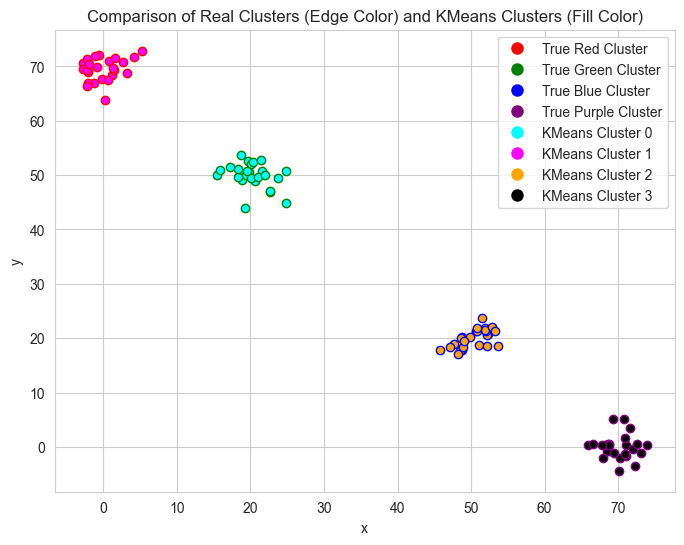

In [34]:
kmeans_labels = cluster(df[['x', 'y']], algorithms["faiss_kmeans"], 4)[1]

df['kmeans_cluster'] = kmeans_labels

# Mapping from KMeans label to color (make sure these are distinct from the original colors)
kmeans_colors = ['cyan', 'magenta', 'orange', 'black']

kmeans_color_map = {i: kmeans_colors[i] for i in range(n_clusters)}

# Visualization of the clusters with distinct colors
plt.figure(figsize=(8, 6))

# Loop through each data point to plot
for idx, row in df.iterrows():
    true_cluster_color = row['cluster']
    kmeans_cluster_color = kmeans_color_map[row['kmeans_cluster']]
    plt.scatter(row['x'], row['y'], color=kmeans_cluster_color, edgecolor=true_cluster_color, label=f'True: {row["cluster"]}, KMeans: {row["kmeans_cluster"]}')

# To avoid duplicate labels in the legend, create custom legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'True {color.capitalize()} Cluster', markerfacecolor=color, markersize=10) for color in colors] + \
                  [Line2D([0], [0], marker='o', color='w', label=f'KMeans Cluster {i}', markerfacecolor=kmeans_colors[i], markersize=10) for i in range(n_clusters)]

plt.title('Comparison of Real Clusters (Edge Color) and KMeans Clusters (Fill Color)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(handles=legend_elements)
plt.show()